In [1]:
import numpy as np

# 토치 불러오기
import torch
import torch.nn as nn

# 데이터셋 불러오기
from torchvision.datasets import MNIST

# 데이터 전처리 및 데이터 로더 불러오기
from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

# 최적화 함수 불러오기
from torch.optim import optimizer

from PIL import Image
import matplotlib.pyplot as plt
import random

import itertools


In [2]:
# 시드 고정
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    return f'현재 사용중인 seed는 [{torch.initial_seed()}]'

fix_seed(1)

'현재 사용중인 seed는 [1]'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
# 이미지 호출
path = '/home/helpme/data'

train_dataset = MNIST(
    root = path,
    train = True,
    transform=transform,
    download=True,
)

test_dataset = MNIST(
    root = path,
    train = False,
    transform=transform,
    download=True
)

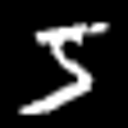

In [5]:
# 이미지 확인
Image.fromarray(train_dataset.data.data[0].numpy()).resize((128,128))

In [6]:
# 데이터 로더 만들기
batch_size = 128

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

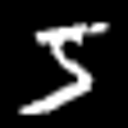

In [7]:
Image.fromarray(train_dataloader.dataset.data[0].numpy()).resize((128, 128))

# VAE 만들기 

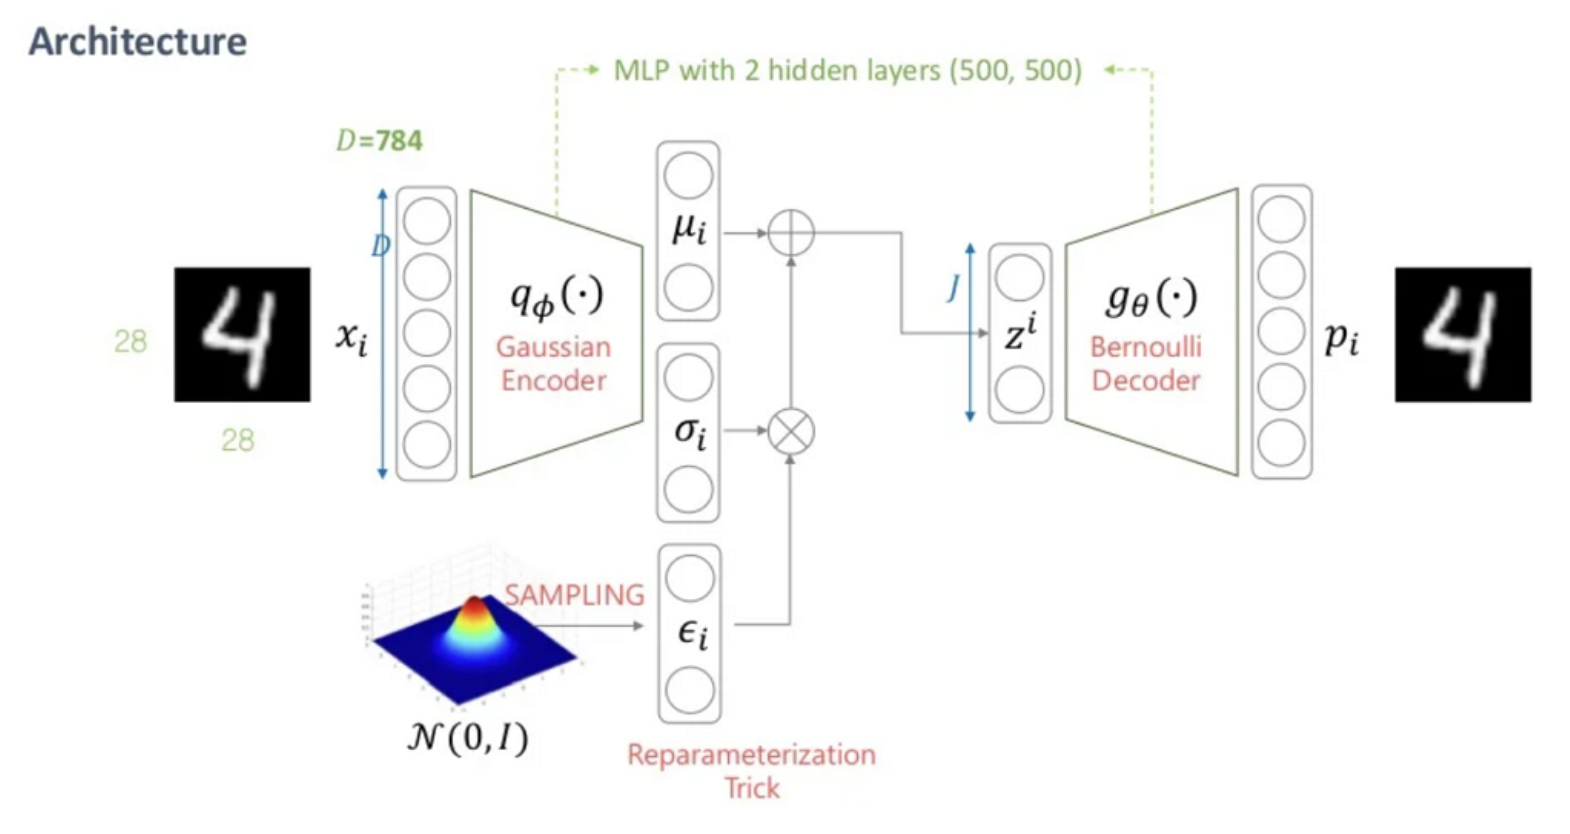

In [8]:
# Encoder 생성
class VAE(nn.Module):
    def __init__(self, x_dim:int, h_dim:int, z_dim:int) -> None:
        super().__init__()
        # 최초 input은 32*32*1 -> flatten으로 784*1 로 변형 필요    
        
        #### 인코더 #####
        # 2 hidden layer로 구성된 Gaussian Encoder(q_phi)
        # input 값을 받아 중간 차원(h)으로 만들어줌(out은 in보다 작아야함)
        self.E_fc1 = nn.Sequential(
            nn.Linear(in_features=x_dim, out_features=h_dim),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )

        # output, 평균(mu)와 표준편차(sigma)가 출력되게끔 만들어야함
        # 이론적으로는 mu와 sigma가 나와야하는데 뉴럴넷을 통과하며 sigma output이 항상 양수라는 보장이 없음
        # 때문에 뉴럴넷을 거친 값이 바로 sigma가 되는 것이 아닌 log variance 값이 나오게 된다고 정의함
        # log variance는 음수가 나오더라도 sigma로 치환하게 된다면 항상 양수를 가지기 때문
        self.mu = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.ReLU(True)
        )
        
        self.log_var = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.ReLU(True)
        )    


        #### 디코더 #####
        self.D_fc1 = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=h_dim),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )


        self.D_fc2 = nn.Sequential(
            nn.Linear(h_dim, x_dim)
        )

    # sampling, 논문에서 나온 reparameterization trick 구현
    # sampling으로 인해 backprop이 불가능한 구조를 해결하기 위해 적용
    # reparameterization은 N(mu, var*I) 에서 샘플링 하던 구조를 mu * std*N(0,I) 구조에서 샘플링 하는 것으로 바꿈
    # torch.randn_like(tensor): 파라미터로 들어 간 Tensor 객체의 사이즈과 똑같은 행렬을 반환하며, 요소들은 정규분포 그래프 상의 랜덤한 값으로 초기화 되어있다
    # https://pytorch.org/docs/stable/generated/torch.randn_like.html    
    def reparameterization(self, mu, log_var):
        std = log_var / 2 # log std^2 에서 2로 나눠주기(var = std^2)
        std = torch.exp(std) # log를 떼어낸 온전한 std
        eps = torch.randn_like(std) # std 를 random하게 sampling 한 값
        sample = mu + std * eps # reparameterization을 통해 얻어내는 최종 값
        return sample

    def encode(self, x):
        # 인코더
        x = self.E_fc1(x)

        # mu, log_var 얻기
        mu = self.mu(x)
        log_var = self.log_var(x)

        return mu, log_var
    
    def decode(self, z):
        z = self.D_fc1(z)
        x_reconst = torch.sigmoid(self.D_fc2(z)) # 마지막에 sigmoid 적용
        return x_reconst
    

    def forward(self, x):
        mu, log_var = self.encode(torch.flatten(x, 1))
        
        # Z 얻기
        z = self.reparameterization(mu, log_var)
        
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [9]:
x_dim = train_dataloader.dataset.data.shape[1] * train_dataloader.dataset.data.shape[2]
h_dim = 512
z_dim = 10

model = VAE(x_dim, h_dim, z_dim)

In [10]:
from torchsummary import summary

summary(model=model, batch_size=1, input_size=(28,28,1), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [1, 512]         401,920
              ReLU-2                   [1, 512]               0
           Dropout-3                   [1, 512]               0
            Linear-4                    [1, 10]           5,130
              ReLU-5                    [1, 10]               0
            Linear-6                    [1, 10]           5,130
              ReLU-7                    [1, 10]               0
            Linear-8                   [1, 512]           5,632
              ReLU-9                   [1, 512]               0
          Dropout-10                   [1, 512]               0
           Linear-11                   [1, 784]         402,192
Total params: 820,004
Trainable params: 820,004
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model.to(device)

Using cuda device


VAE(
  (E_fc1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (E_fc2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (mu): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): ReLU(inplace=True)
  )
  (log_var): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): ReLU(inplace=True)
  )
  (D_fc1): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (D_fc2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (D_fc3): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [12]:
# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion.to(device=device)

BCELoss()

In [13]:
# 학습
# encoder는 가우시안 인코더, 디코더는 베르누이 디코더를 가정
num_epochs = 30 # 에폭 설정

loss_arr = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):  
        images, labels = data
        images = torch.flatten(images,1)
        images = images.to(device)

        #Forward pass
        x_reconst, mu, log_var = model(images)
        
        # 예측에 따른 손실 계산 및 출력
        reconst_loss = criterion(x_reconst, images) # 예측값과 원본 
        # regularization, 1/2(mu^2 + var - log_var - 1)
        # log가 씌워진 var를 사용하였기 때문에 맞춰서 loss 설정
        kl_loss = 0.5 * torch.sum((mu**2) + log_var.exp() - log_var - 1)

        loss = reconst_loss + kl_loss # 위에서 선언한 2가지 loss 합치기

        # backward pass 
        optimizer.zero_grad() # 가중치 변화를 0으로 만들고
        loss.backward() # 역전파를 수행하고
        optimizer.step() # 가중치를 갱신

        running_loss += loss.item()
        loss_arr.append(loss.item())
        # 100번에 한번씩 loss 출력
        if i % 59 == 58: 
            print(f'[Training epoch : {epoch+1}, [{i * len(images)} / {len(train_dataloader.dataset)}] ({100 * i / len(train_dataloader):0.0f}%), Loss : {running_loss / len(train_dataloader.dataset):0.6f}, reconst error : {reconst_loss:0.2f}, kl divergence : {kl_loss:0.2f}]')
            running_loss = 0.0
print('학습종료!')

[Training epoch : 1, [7424 / 60000] (12%), Loss : 31.894775, reconst error : 27329.27, kl divergence : 632.24]
[Training epoch : 1, [14976 / 60000] (25%), Loss : 25.337415, reconst error : 24161.82, kl divergence : 911.02]
[Training epoch : 1, [22528 / 60000] (38%), Loss : 24.051088, reconst error : 22559.45, kl divergence : 1238.15]
[Training epoch : 1, [30080 / 60000] (50%), Loss : 23.589270, reconst error : 23395.24, kl divergence : 1186.50]
[Training epoch : 1, [37632 / 60000] (63%), Loss : 23.185887, reconst error : 21606.52, kl divergence : 1258.90]
[Training epoch : 1, [45184 / 60000] (75%), Loss : 23.269618, reconst error : 23621.90, kl divergence : 1266.78]
[Training epoch : 1, [52736 / 60000] (88%), Loss : 22.959952, reconst error : 22546.25, kl divergence : 1381.55]
[Training epoch : 2, [7424 / 60000] (12%), Loss : 22.600431, reconst error : 20652.66, kl divergence : 1659.50]
[Training epoch : 2, [14976 / 60000] (25%), Loss : 22.287889, reconst error : 20256.87, kl divergenc

# 테스트

In [14]:
# test 
# model.eval() # drop out 같은 학습에만 필요하고 test에는 불필요한 층을 비활성화
with torch.no_grad(): # gradient 연산을 멈춘 상태로 계산, 메모리 절약 및 연산속도 증가
    for data in test_dataloader:
        images, labels = data
        images = torch.flatten(images, 1)
        images = images.to(device)
        
        #Forward pass
        x_reconst, mu, log_var = model(images)

        
        # 결과 예측
        # x_reconst,  mu, log_var, z = model(images) # 모델 예측 시행
        x_reconst
        break

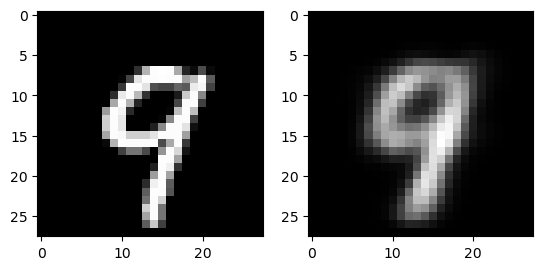

In [15]:
num = 12
plt.subplot(1,2,1)
plt.imshow(test_dataloader.dataset.data[num])
plt.gray()

plt.subplot(1,2,2)
plt.imshow(x_reconst[num].detach().cpu().numpy().reshape((28,28)))
plt.show()

In [16]:
with torch.no_grad():
    z = torch.randn(batch_size, z_dim).to(device) # N(0, 1)에서 z 샘플링
    sample = model.decode(z).to(device)

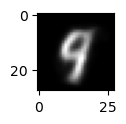

In [17]:
plt.figure(figsize=(1,1))
plt.imshow((sample[34].detach().cpu().numpy().reshape((28,28))))